In [ ]:
# ===================================================================
# Cell 1: Setup and Imports
# ===================================================================
import pandas as pd
import numpy as np
import os
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler

# For TabPFN Model
from tabpfn import TabPFNClassifier
from sklearn.metrics import f1_score

# --- NOTE ---
# Make sure the sompy library files (sompy_isom.py, codebook.py, aux_fun.py, etc.)
# are in the same directory as this notebook for the import below to work.
from folder.sompy_isom import SOMFactory
from folder.aux_fun import aux_fun

# --- Installation Note ---
# !pip install tabpfn sklearn pandas seaborn matplotlib tqdm sompy

print("Setup Complete!")

In [ ]:
# ===================================================================
# Cell 2: NEW - Intelligent Synthetic Data Generator using sompy
# ===================================================================
# This cell replaces the old ModifiedSOM class and generator function.

def generate_isom_data_advanced(df_real, target_column, num_synthetic_total, strategy="decision_boundary", roi_percentile=20, boundary_width=0.25):
    """
    Generates synthetic data by starting from real data points and exploring towards 
    neighboring prototypes within the Region of Interest (RoI).

    Args:
        df_real (pd.DataFrame): The real data to learn from.
        target_column (str): The name of the binary target column.
        num_synthetic_total (int): The total number of synthetic samples to generate.
        strategy (str): "decision_boundary" or "hitmap".
        roi_percentile (int): Percentile for 'hitmap' strategy.
        boundary_width (float): Width around 0.5 for 'decision_boundary' strategy.

    Returns:
        pd.DataFrame: A DataFrame containing the generated synthetic data.
    """
    if num_synthetic_total <= 0:
        return pd.DataFrame(columns=df_real.columns)

    print(f"Generating {num_synthetic_total} ADVANCED synthetic samples (Strategy: {strategy})...")

    # --- 1. Prepare Data and Train iSOM (Same as before) ---
    X_real = df_real.drop(columns=[target_column])
    y_real = df_real[target_column]
    data_for_som = np.hstack((X_real.values, y_real.values.reshape(-1, 1)))
    component_names = list(df_real.columns)

    sm = SOMFactory.build(data_for_som, normalization='range', initialization='pca', component_names=component_names)
    sm.som_lininit()
    sm.train(request_id=f'isom_gen_advanced_{strategy}', verbose=None)
    
    af = aux_fun()
    codebook = sm.codebook.matrix

    # --- 2. Identify Region of Interest (RoI) (Same as before) ---
    if strategy == "decision_boundary":
        target_values = codebook[:, -1]
        lower_bound, upper_bound = 0.5 - boundary_width, 0.5 + boundary_width
        roi_node_indices = np.where((target_values >= lower_bound) & (target_values <= upper_bound))[0]
    elif strategy == "hitmap":
        hits = af.som_hits(sm, sm._data)
        hit_threshold = np.percentile(hits[hits > 0], roi_percentile) if len(hits[hits > 0]) > 0 else 0
        roi_node_indices = np.where(hits >= hit_threshold)[0]
    else:
        raise ValueError("Invalid strategy.")

    if len(roi_node_indices) == 0:
        print("Warning: No RoI nodes found. Using all prototypes as fallback.")
        roi_node_indices = np.arange(sm.codebook.nnodes)
    
    print(f"  > RoI contains {len(roi_node_indices)} prototypes.")

    # --- 3. REFINED Synthetic Data Generation ---
    synthetic_samples = []
    rng = np.random.default_rng(42)
    neighborhood_matrix = af.som_unit_neighs(sm)
    bmus = af.som_bmus(sm, data_for_som) # Get Best Matching Unit for each real point

    for _ in tqdm(range(num_synthetic_total), desc="  > Generating samples", leave=False):
        # a. Pick a random prototype from the RoI
        p1_idx = rng.choice(roi_node_indices)
        p1 = codebook[p1_idx]

        # b. Find a REAL data point mapped to this prototype
        real_points_mapped_to_p1_indices = np.where(bmus == p1_idx)[0]
        if len(real_points_mapped_to_p1_indices) == 0:
            continue # Skip if no real data points map here
        
        d_real_idx = rng.choice(real_points_mapped_to_p1_indices)
        d_real_norm = sm._data[d_real_idx] # Use the normalized version of the real data point

        # c. Find a neighboring prototype also in the RoI
        neighbor_indices = np.where(neighborhood_matrix[p1_idx] == 1)[0]
        roi_neighbors = np.intersect1d(neighbor_indices, roi_node_indices)
        
        if len(roi_neighbors) > 0:
            p2_idx = rng.choice(roi_neighbors)
            p2 = codebook[p2_idx]
        else:
            p2_idx = rng.choice(roi_node_indices)
            p2 = codebook[p2_idx]

        # d. Create new point by moving from the real point towards the neighbor
        alpha = rng.random() # Random fraction of the distance to move
        new_sample_norm = d_real_norm + alpha * (p2 - p1)

        # e. Add noise, denormalize, and assign class (Same as before)
        features_norm = new_sample_norm[:-1]
        noise = rng.normal(0, 0.05, size=features_norm.shape)
        features_norm_noisy = np.clip(features_norm + noise, 0, 1)

        denormalized_data_wrapper = np.array([np.append(features_norm_noisy, 0)])
        final_features = sm._normalizer.denormalize_by(data_for_som, denormalized_data_wrapper)[:, :-1]

        target_prob_norm = np.clip(new_sample_norm[-1], 0, 1)
        final_class = rng.binomial(1, target_prob_norm)

        synthetic_samples.append(np.append(final_features.flatten(), final_class))

    final_synthetic_df = pd.DataFrame(synthetic_samples, columns=df_real.columns)
    final_synthetic_df[target_column] = final_synthetic_df[target_column].astype(int)

    return final_synthetic_df

# def generate_isom_data(df_real, target_column, num_synthetic_total, strategy="decision_boundary", roi_percentile=90, boundary_width=0.25):
#     """
#     Generates high-quality synthetic data using the robust iSOM implementation from the paper.

#     Args:
#         df_real (pd.DataFrame): The real data to learn from.
#         target_column (str): The name of the binary target column (0s and 1s).
#         num_synthetic_total (int): The total number of synthetic samples to generate.
#         strategy (str, optional): The strategy for defining the Region of Interest (RoI).
#                                   Options are "decision_boundary" or "hitmap". Defaults to "decision_boundary".
#         roi_percentile (int, optional): For 'hitmap' strategy, the percentile of top hits to use for the RoI.
#                                         (e.g., 75 means use the top 25% most hit nodes). Defaults to 75.
#         boundary_width (float, optional): For 'decision_boundary', the width around 0.5 to define the boundary.
#                                           (e.g., 0.25 means a range of 0.25 to 0.75). Defaults to 0.25.

#     Returns:
#         pd.DataFrame: A DataFrame containing the generated synthetic data.
#     """
#     if num_synthetic_total <= 0:
#         return pd.DataFrame(columns=df_real.columns)

#     print(f"Generating {num_synthetic_total} synthetic samples using iSOM (Strategy: {strategy})...")

#     X_real = df_real.drop(columns=[target_column])
#     y_real = df_real[target_column]
#     feature_names = X_real.columns
#     X_real_np = X_real.values
#     y_real_np = y_real.values.reshape(-1, 1)

#     # Combine features and target for SOM training
#     data_for_som = np.hstack((X_real_np, y_real_np))
#     component_names = list(df_real.columns)


#     # 1. Create the iSOM object
#     sm = SOMFactory.build(data_for_som, normalization='range', initialization='pca', component_names=component_names)

#     # This creates the proper 2D codebook matrix using PCA.
#     sm.som_lininit() 

#     # 3. Now, train the initialized SOM
#     sm.train(request_id=f'isom_gen_{strategy}', verbose=None)

#     # Instantiate auxiliary functions for analysis
#     af = aux_fun()

#     # 2. Identify the Region of Interest (RoI) based on the chosen strategy
#     codebook = sm.codebook.matrix
#     roi_node_indices = []

#     if strategy == "decision_boundary":
#         print(f"  > Defining RoI as decision boundary (target values between {0.5 - boundary_width} and {0.5 + boundary_width}).")
#         target_values = codebook[:, -1] # Last column is the target
#         lower_bound = 0.5 - boundary_width
#         upper_bound = 0.5 + boundary_width
#         roi_node_indices = np.where((target_values >= lower_bound) & (target_values <= upper_bound))[0]

#     elif strategy == "hitmap":
#         print(f"  > Defining RoI from the top {100 - roi_percentile}% most hit nodes.")
#         hits = af.som_hits(sm, sm._data)
#         hit_threshold = np.percentile(hits[hits > 0], roi_percentile) if len(hits[hits > 0]) > 0 else 0
#         roi_node_indices = np.where(hits >= hit_threshold)[0]

#     else:
#         raise ValueError("Invalid strategy. Choose 'decision_boundary' or 'hitmap'.")

#     if len(roi_node_indices) == 0:
#         print("Warning: No nodes found in the Region of Interest. Using the entire codebook as a fallback.")
#         roi_node_indices = np.arange(sm.codebook.nnodes)

#     print(f"  > Region of Interest contains {len(roi_node_indices)} out of {sm.codebook.nnodes} prototypes.")

#     # 3. Generate new samples by interpolating within the RoI
#     synthetic_samples = []
#     rng = np.random.default_rng(42)
#     neighborhood_matrix = af.som_unit_neighs(sm)

#     for _ in tqdm(range(num_synthetic_total), desc="  > Generating samples", leave=False):
#         p1_idx = rng.choice(roi_node_indices)
#         p1 = codebook[p1_idx]

#         neighbor_indices = np.where(neighborhood_matrix[p1_idx] == 1)[0]
#         roi_neighbors = np.intersect1d(neighbor_indices, roi_node_indices)

#         p2 = codebook[rng.choice(roi_neighbors)] if len(roi_neighbors) > 0 else codebook[rng.choice(roi_node_indices)]

#         alpha = rng.random()
#         new_sample_norm = alpha * p1 + (1 - alpha) * p2

#         features_norm = new_sample_norm[:-1]
#         noise = rng.normal(0, 0.05, size=features_norm.shape)
#         features_norm_noisy = np.clip(features_norm + noise, 0, 1)

#         final_features = sm._normalizer.denormalize_by(data_for_som, np.array([np.append(features_norm_noisy, 0)]))[:, :-1]

#         target_prob_norm = np.clip(new_sample_norm[-1], 0, 1)
#         final_class = rng.binomial(1, target_prob_norm)

#         synthetic_samples.append(np.append(final_features.flatten(), final_class))

#     final_synthetic_df = pd.DataFrame(synthetic_samples, columns=df_real.columns)
#     final_synthetic_df[target_column] = final_synthetic_df[target_column].astype(int)

#     return final_synthetic_df

In [ ]:
# ===================================================================
# Cell 3: Helper Functions (Data Loading) - UNCHANGED
# ===================================================================
def read_data(path):
    _, ext = os.path.splitext(path)
    if ext == ".parquet": return pd.read_parquet(path)
    elif ext == ".csv": return pd.read_csv(path, index_col=0)

def load_data(base_path, dataset_name):
    with open(os.path.join(base_path, dataset_name, f"{dataset_name}.meta.json")) as f: meta = json.load(f)
    train_data = read_data(os.path.join(base_path, dataset_name, f"{dataset_name}.{meta['format']}"))
    
    test_path = os.path.join(base_path, dataset_name, f"{dataset_name}_test.{meta['format']}")
    if os.path.exists(test_path):
        print(f"Found dedicated test set for {dataset_name}.")
        test_data = read_data(test_path)
    else:
        print(f"No dedicated test set for {dataset_name}. Splitting will be handled by index file.")
        test_data = None
        
    return train_data, test_data, meta

def get_indices_for_repeat(base_path, dataset_name, repeat_idx):
    train_idx_file = os.path.join(base_path, dataset_name, "train_indices.parquet")
    train_idx_splits = pd.read_parquet(train_idx_file)
    col_name = train_idx_splits.columns[repeat_idx]
    return train_idx_splits[col_name].values


In [ ]:
# ===================================================================
# Cell 4: Main Configuration - UNCHANGED
# ===================================================================
BASE_DATA_PATH = "data"
DATASETS_TO_RUN = [
    "airfoil_cl"
    # "airfoil_cl", "airfoil_cl_m", "framed_safety", "framed_validity", 
    # "solar_hex", "welded_beam", "welded_beam_balanced"
]
REPEATS = 1

# --- Experiment Parameters ---
STARTING_REAL_FRACTIONS = [0.1, 0.3, 0.5]
POOL_TRAINING_FRACTIONS = [0.2, 0.4, 0.6, 0.8, 1.0]
BASELINE_REAL_FRACTIONS = np.arange(0.1, 1.1, 0.1).round(1)

In [ ]:
# # ===================================================================
# # Cell 5: Main Experiment Loop - MODIFIED for two strategies
# # ===================================================================
# all_results = []
# classifier = TabPFNClassifier(device="cuda")

# for dataset_name in tqdm(DATASETS_TO_RUN, desc="Overall Dataset Progress"):
#     print(f"\n===== Running Dataset: {dataset_name} =====")
    
#     full_train_data, test_data_from_file, meta = load_data(BASE_DATA_PATH, dataset_name)
#     y_column = meta["label"]

#     if pd.api.types.is_float_dtype(full_train_data[y_column]):
#         threshold = full_train_data[y_column].median()
#         full_train_data[y_column] = (full_train_data[y_column] <= threshold).astype(int)
#         if test_data_from_file is not None:
#             test_data_from_file[y_column] = (test_data_from_file[y_column] <= threshold).astype(int)

#     X_columns = full_train_data.columns.drop(y_column)
#     full_train_size = len(full_train_data)

#     for i in range(REPEATS):
#         shuffled_indices = get_indices_for_repeat(BASE_DATA_PATH, dataset_name, i)
        
#         if test_data_from_file is not None:
#             X_test, y_test = test_data_from_file[X_columns], test_data_from_file[y_column]
#         else:
#             train_idx_for_split, test_idx_for_split = np.split(shuffled_indices, [int(0.8 * len(shuffled_indices))])
#             X_test, y_test = full_train_data.loc[test_idx_for_split, X_columns], full_train_data.loc[test_idx_for_split, y_column]

#         # --- Baseline Experiment ---
#         for real_fraction in tqdm(BASELINE_REAL_FRACTIONS, desc=f"Repeat {i+1} Baseline", leave=False):
#             n_real = int(real_fraction * full_train_size)
#             if n_real < 2: continue
#             train_indices = shuffled_indices[:n_real]
#             X_train, y_train = full_train_data.loc[train_indices, X_columns], full_train_data.loc[train_indices, y_column].astype(int)

#             classifier.fit(X_train, y_train)
#             y_pred = classifier.predict(X_test)
#             score = f1_score(y_test.astype(int), y_pred, average="macro")
#             all_results.append({"dataset": dataset_name, "experiment": "Baseline (Real Only)", "total_fraction": real_fraction, "f1_score": score})

#         # --- Augmentation Experiment ---
#         # ### --- CHANGE: Loop over the two strategies --- ###
#         AUGMENTATION_STRATEGIES = ["hitmap"]
#         for strategy in tqdm(AUGMENTATION_STRATEGIES, desc=f"Repeat {i+1} Augmentation Strategies", leave=False):
#             for start_fraction in tqdm(STARTING_REAL_FRACTIONS, desc=f"  Start Fractions ({strategy})", leave=False):
#                 n_real = int(start_fraction * full_train_size)
#                 if n_real < 2: continue
#                 real_subset = full_train_data.loc[shuffled_indices[:n_real]]
                
#                 n_synthetic = full_train_size - n_real
#                 # ### --- CHANGE: Calling the new iSOM generator with the current strategy --- ###
#                 synthetic_data = generate_isom_data_advanced(real_subset, y_column, n_synthetic, strategy=strategy)
#                 data_pool = pd.concat([real_subset, synthetic_data]).sample(frac=1, random_state=i)
                
#                 for pool_fraction in POOL_TRAINING_FRACTIONS:
#                     n_pool_samples = int(pool_fraction * len(data_pool))
#                     if n_pool_samples < 2: continue
#                     training_subset_from_pool = data_pool.head(n_pool_samples)
#                     X_train, y_train = training_subset_from_pool[X_columns], training_subset_from_pool[y_column].astype(int)
                    
#                     classifier.fit(X_train, y_train)
#                     y_pred = classifier.predict(X_test)
#                     score = f1_score(y_test.astype(int), y_pred, average="macro")

#                     # ### --- CHANGE: Update experiment name to be descriptive --- ###
#                     exp_name = f"Augmented ({strategy})"
#                     all_results.append({"dataset": dataset_name, "experiment": exp_name, "start_fraction": start_fraction, "total_fraction": pool_fraction, "f1_score": score})

# results_df = pd.DataFrame(all_results)
# print("\n\n===== ALL EXPERIMENTS COMPLETE! =====\n")
# ===================================================================
# Cell 5: Main Experiment Loop - MODIFIED for two strategies & TSTR
# ===================================================================
all_results = []
classifier = TabPFNClassifier(device="cuda")

for dataset_name in tqdm(DATASETS_TO_RUN, desc="Overall Dataset Progress"):
    print(f"\n===== Running Dataset: {dataset_name} =====")
    
    full_train_data, test_data_from_file, meta = load_data(BASE_DATA_PATH, dataset_name)
    y_column = meta["label"]

    if pd.api.types.is_float_dtype(full_train_data[y_column]):
        threshold = full_train_data[y_column].median()
        full_train_data[y_column] = (full_train_data[y_column] <= threshold).astype(int)
        if test_data_from_file is not None:
            test_data_from_file[y_column] = (test_data_from_file[y_column] <= threshold).astype(int)

    X_columns = full_train_data.columns.drop(y_column)
    full_train_size = len(full_train_data)

    for i in range(REPEATS):
        shuffled_indices = get_indices_for_repeat(BASE_DATA_PATH, dataset_name, i)
        
        if test_data_from_file is not None:
            X_test, y_test = test_data_from_file[X_columns], test_data_from_file[y_column]
        else:
            train_idx_for_split, test_idx_for_split = np.split(shuffled_indices, [int(0.8 * len(shuffled_indices))])
            X_test, y_test = full_train_data.loc[test_idx_for_split, X_columns], full_train_data.loc[test_idx_for_split, y_column]

        # --- Baseline Experiment ---
        for real_fraction in tqdm(BASELINE_REAL_FRACTIONS, desc=f"Repeat {i+1} Baseline", leave=False):
            n_real = int(real_fraction * full_train_size)
            if n_real < 2: continue
            train_indices = shuffled_indices[:n_real]
            X_train, y_train = full_train_data.loc[train_indices, X_columns], full_train_data.loc[train_indices, y_column].astype(int)

            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            score = f1_score(y_test.astype(int), y_pred, average="macro")
            all_results.append({"dataset": dataset_name, "experiment": "Baseline (Real Only)", "total_fraction": real_fraction, "f1_score": score})

        # --- Augmentation & TSTR-Only Experiments ---
        # ### --- NEW: Loop over both strategies --- ###
        AUGMENTATION_STRATEGIES = ["hitmap", "decision_boundary"]
        
        for strategy in tqdm(AUGMENTATION_STRATEGIES, desc=f"Repeat {i+1} Augmentation Strategies", leave=False):
            for start_fraction in tqdm(STARTING_REAL_FRACTIONS, desc=f"  Start Fractions ({strategy})", leave=False):
                n_real = int(start_fraction * full_train_size)
                if n_real < 2: continue
                real_subset = full_train_data.loc[shuffled_indices[:n_real]]
                
                n_synthetic = full_train_size - n_real
                synthetic_data = generate_isom_data_advanced(real_subset, y_column, n_synthetic, strategy=strategy)
                
                if synthetic_data.empty:
                    print(f"Skipping {strategy} for {dataset_name} @ {start_fraction} - no synthetic data.")
                    continue

                # --- NEW: "TSTR-only" Sanity Check Experiment ---
                # We train *only* on synthetic data, using a fraction of it
                # matching the "pool_fraction" loop for a fair comparison of data size
                for pool_fraction in POOL_TRAINING_FRACTIONS:
                    n_pool_samples = int(pool_fraction * len(synthetic_data))
                    if n_pool_samples < 2: continue
                    
                    training_subset_from_pool = synthetic_data.head(n_pool_samples)
                    X_train, y_train = training_subset_from_pool[X_columns], training_subset_from_pool[y_column].astype(int)
                    
                    classifier.fit(X_train, y_train)
                    y_pred = classifier.predict(X_test)
                    score = f1_score(y_test.astype(int), y_pred, average="macro")
                    
                    exp_name = f"Synthetic Only ({strategy})"
                    all_results.append({"dataset": dataset_name, "experiment": exp_name, "start_fraction": start_fraction, "total_fraction": pool_fraction, "f1_score": score})

                # --- "Augmented" Experiment (Your original one) ---
                data_pool = pd.concat([real_subset, synthetic_data]).sample(frac=1, random_state=i)
                
                for pool_fraction in POOL_TRAINING_FRACTIONS:
                    n_pool_samples = int(pool_fraction * len(data_pool))
                    if n_pool_samples < 2: continue
                    training_subset_from_pool = data_pool.head(n_pool_samples)
                    X_train, y_train = training_subset_from_pool[X_columns], training_subset_from_pool[y_column].astype(int)
                    
                    classifier.fit(X_train, y_train)
                    y_pred = classifier.predict(X_test)
                    score = f1_score(y_test.astype(int), y_pred, average="macro")

                    exp_name = f"Augmented ({strategy})"
                    all_results.append({"dataset": dataset_name, "experiment": exp_name, "start_fraction": start_fraction, "total_fraction": pool_fraction, "f1_score": score})

results_df = pd.DataFrame(all_results)
print("\n\n===== ALL EXPERIMENTS COMPLETE! =====\n")

In [ ]:
# # ===================================================================
# # Cell 6: Visualize All Results - FINAL CORRECTED VERSION
# # ===================================================================
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import pandas as pd

# plt.style.use('seaborn-v0_8-whitegrid')

# # --- 1. Prepare the data for plotting ---

# # Calculate the starting F1 score for scatter plot points
# aug_df = results_df[results_df['experiment'] != "Baseline (Real Only)"].copy()
# aug_df['start_f1'] = aug_df.groupby(['dataset', 'experiment', 'start_fraction'])['f1_score'].transform('first')

# # If the start_f1 column already exists from a previous run, remove it
# if 'start_f1' in results_df.columns:
#     results_df = results_df.drop(columns=['start_f1'])

# # Merge the start_f1 column back into the main DataFrame
# results_df = results_df.merge(aug_df[['start_f1']], left_index=True, right_index=True, how='left')

# # --- FIX: Create a new, more descriptive column for the legend ---
# def create_exp_label(row):
#     if "Augmented" in row['experiment']:
#         start_pct = int(row['start_fraction'] * 100)
#         strategy = row['experiment'].split('(')[1].split(')')[0]
#         return f"Augmented ({strategy}, Start {start_pct}%)"
#     return "Baseline (Real Only)"

# results_df['exp_label'] = results_df.apply(create_exp_label, axis=1)


# # --- 2. Loop through each strategy to create separate plots ---
# AUGMENTATION_STRATEGIES = ["hitmap"]

# for strategy in AUGMENTATION_STRATEGIES:
    
#     # Define the order for the legend in this specific plot
#     experiment_order = (
#         ["Baseline (Real Only)"] + 
#         [f"Augmented ({strategy}, Start {int(f*100)}%)" for f in STARTING_REAL_FRACTIONS]
#     )
    
#     # Filter the data for the current strategy and the baseline
#     plot_df = results_df[
#         results_df['experiment'].isin(["Baseline (Real Only)", f"Augmented ({strategy})"])
#     ]

#     # Create the FacetGrid
#     g = sns.FacetGrid(
#         plot_df, 
#         col="dataset", 
#         col_wrap=4, 
#         hue="exp_label",  # <-- Use the new descriptive label for color
#         hue_order=experiment_order,
#         col_order=DATASETS_TO_RUN,
#         height=4, 
#         aspect=1.2, 
#         sharey=False,
#         legend_out=True
#     )

#     # Map the lineplot
#     g.map_dataframe(
#         sns.lineplot,
#         x="total_fraction",
#         y="f1_score",
#         markers=True,
#         errorbar="sd"
#     ).set_titles("{col_name}")

#     # Map the scatterplot for starting points
#     g.map_dataframe(
#         sns.scatterplot,
#         x='start_fraction',
#         y='start_f1',
#         size=100,
#         legend=False
#     )

#     # Add titles and labels
#     g.set_axis_labels("Training Data Fraction", "F1 Score (Macro)")
#     g.fig.suptitle(f"Performance: Baseline vs. Augmented ({strategy} strategy)", y=1.03, fontsize=18)
#     g.add_legend(title="Experiment Type")
#     g.fig.tight_layout()
    
#     # Save the figure with a unique name
#     g.fig.savefig(f"my_results_plot_{strategy}.png", bbox_inches='tight', dpi=150)
#     plt.close(g.fig) # Close the figure to free up memory before the next loop

# print("Plots have been saved to the directory.")
# ===================================================================
# Cell 6: Visualize All Results - FINAL CORRECTED VERSION
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use('seaborn-v0_8-whitegrid')

# --- 1. Prepare the data for plotting ---

# Calculate the starting F1 score for scatter plot points
# This logic remains the same, but we filter for 'Augmented'
aug_df = results_df[results_df['experiment'].str.contains("Augmented")].copy()
aug_df['start_f1'] = aug_df.groupby(['dataset', 'experiment', 'start_fraction'])['f1_score'].transform('first')

# If the start_f1 column already exists from a previous run, remove it
if 'start_f1' in results_df.columns:
    results_df = results_df.drop(columns=['start_f1'])

# Merge the start_f1 column back into the main DataFrame
results_df = results_df.merge(aug_df[['start_f1']], left_index=True, right_index=True, how='left')

# --- FIX: Create a new, more descriptive column for the legend ---
def create_exp_label(row):
    exp = row['experiment']
    if "Augmented" in exp:
        start_pct = int(row['start_fraction'] * 100)
        strategy = exp.split('(')[1].split(')')[0]
        return f"Augmented ({strategy}, Start {start_pct}%)"
    if "Synthetic Only" in exp:
        start_pct = int(row['start_fraction'] * 100)
        strategy = exp.split('(')[1].split(')')[0]
        return f"Synthetic Only ({strategy}, Start {start_pct}%)"
    return "Baseline (Real Only)"

results_df['exp_label'] = results_df.apply(create_exp_label, axis=1)


# --- 2. Loop through each strategy to create separate plots ---
# ### --- NEW: Update to include both strategies --- ###
AUGMENTATION_STRATEGIES = ["hitmap", "decision_boundary"]

for strategy in AUGMENTATION_STRATEGIES:
    
    # Define the order for the legend in this specific plot
    experiment_order = (
        ["Baseline (Real Only)"] + 
        [f"Synthetic Only ({strategy}, Start {int(f*100)}%)" for f in STARTING_REAL_FRACTIONS] +
        [f"Augmented ({strategy}, Start {int(f*100)}%)" for f in STARTING_REAL_FRACTIONS]
    )
    
    # Filter the data for the current strategy and the baseline
    plot_df = results_df[
        (results_df['experiment'] == "Baseline (Real Only)") |
        (results_df['experiment'] == f"Augmented ({strategy})") |
        (results_df['experiment'] == f"Synthetic Only ({strategy})")
    ]
    
    if plot_df.empty:
        print(f"No data for strategy '{strategy}', skipping plot.")
        continue

    # Create the FacetGrid
    g = sns.FacetGrid(
        plot_df, 
        col="dataset", 
        col_wrap=4, 
        hue="exp_label",  # <-- Use the new descriptive label for color
        hue_order=experiment_order,
        col_order=DATASETS_TO_RUN,
        height=4, 
        aspect=1.2, 
        sharey=False,
        legend_out=True
    )

    # Map the lineplot
    g.map_dataframe(
        sns.lineplot,
        x="total_fraction",
        y="f1_score",
        markers=True,
        errorbar="sd"
    ).set_titles("{col_name}")

    # Map the scatterplot for starting points (only for 'Augmented' lines)
    g.map_dataframe(
        sns.scatterplot,
        x='start_fraction',
        y='start_f1',
        size=100,
        legend=False
    )

    # Add titles and labels
    g.set_axis_labels("Training Data Fraction", "F1 Score (Macro)")
    g.fig.suptitle(f"Performance: Baseline vs. Synthetic vs. Augmented ({strategy} strategy)", y=1.03, fontsize=18)
    g.add_legend(title="Experiment Type")
    g.fig.tight_layout()
    
    # Save the figure with a unique name
    g.fig.savefig(f"utility_results_plot_{strategy}.png", bbox_inches='tight', dpi=150)
    plt.close(g.fig) # Close the figure to free up memory before the next loop

print("Plots have been saved to the directory.")

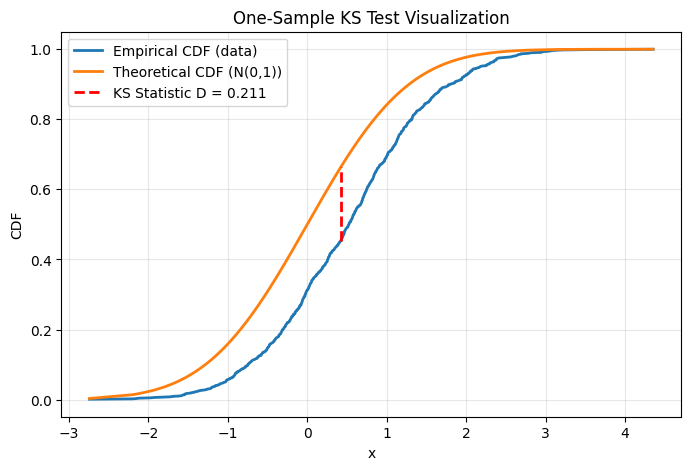

KS Statistic: 0.3949,  p-value: 0.0000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm

# Generate sample data
np.random.seed(42)
data = np.random.normal(0.5, 1, 1000)  # true mean=0.5, std=1

# Perform KS test against N(0,1)
stat, p = kstest(data, 'norm', args=(0, 1))

# Compute empirical CDF of sample
x = np.sort(data)
y_emp = np.arange(1, len(x)+1) / len(x)

# Compute theoretical CDF from N(0,1)
y_theo = norm.cdf(x, loc=0, scale=1)

# Find maximum difference
D = np.max(np.abs(y_emp - y_theo))
x_D = x[np.argmax(np.abs(y_emp - y_theo))]

# Plot both CDFs
plt.figure(figsize=(8,5))
plt.plot(x, y_emp, label='Empirical CDF (data)', lw=2)
plt.plot(x, y_theo, label='Theoretical CDF (N(0,1))', lw=2)

# Highlight KS distance
plt.vlines(x_D, y_emp[np.argmax(np.abs(y_emp - y_theo))], 
           y_theo[np.argmax(np.abs(y_emp - y_theo))],
           color='red', linestyle='--', lw=2,
           label=f'KS Statistic D = {D:.3f}')

plt.title('One-Sample KS Test Visualization')
plt.xlabel('x')
plt.ylabel('CDF')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"KS Statistic: {stat:.4f},  p-value: {p:.4f}")
